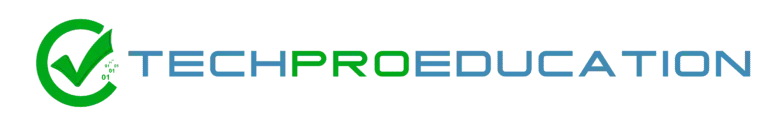

# NLP Application with ML

## Classification of Tweets Data

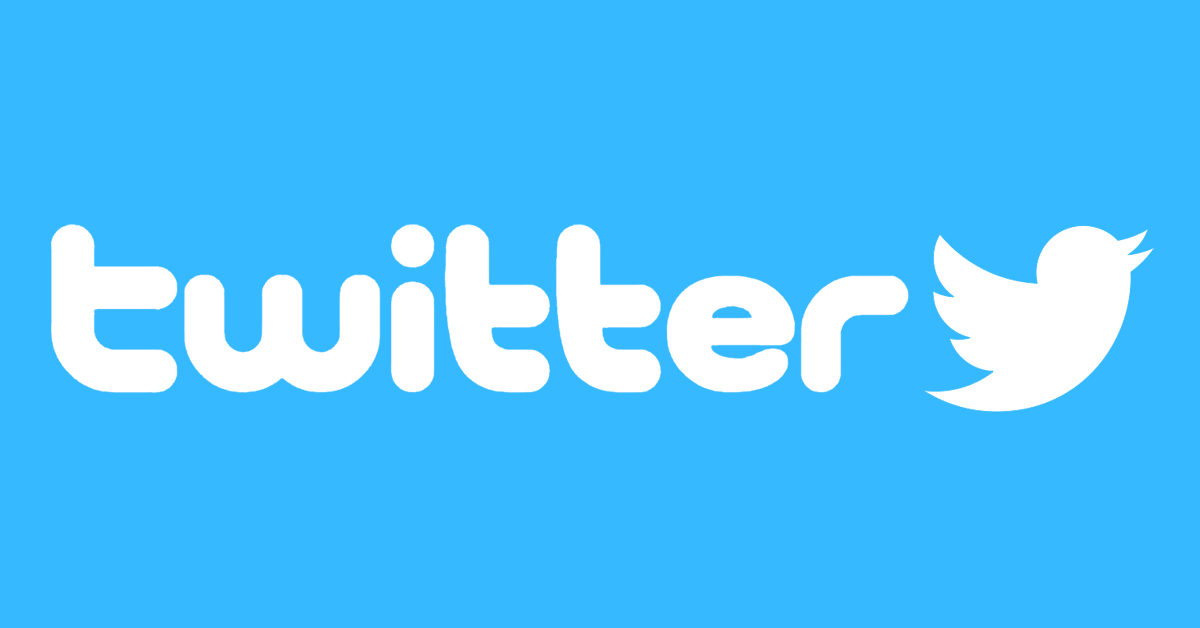

In [ ]:
# 1- bu notebook'ta önce datayi oku ve gerekli featuresleri al
# 2- Datayi tanimak icin görsellestirmeler yap  
# 3- stopwords'larden n't ve not kelimeleri cikariliyor, cünkü bize lazim olacaklar
# 4- cleaning fonksiyonu ile temizlik yapilacak,http:wwww,@,#, bu isaretler temizlenecek, lower yapilacak, stopword uygulanacak,cleaning fonksiyonu apply(cleaning) ile uygulanacak
# 5- Train test split yapiliyor
    # X = df2['text']
    # y = df2['airline_sentiment']
# 6- istersen Count vectorization ile dataya vector halina cevir, burda kelimenin metinde gecen tüm kelimeleri unique olarak bir features tablosu yapiyor
# ve alacagi cümledeki kelimeler nelerde onlarin karsilarina gelen yerlere get_dummies gibi 0,1 yaziyor
# istersende asagida yaptigi gibi TF_IDF yapabiiriz, burda ise kelimenin cümle icindeki oranini bulup ve diger cümlelerde de geciyormu diye bakip ordaki oranida bulup carpiyor
# kendi icindeki Tf, baska cümlelerdeki de IDF oluyor
# bu ikisinden birini yapmalisin bunlar birbirinin alternatifi, ama TF IDf daha iyi duruyor gibi

# 7- en sonda modellere koyduktan sonra grafik cizerek hangi modelin daha iyi oldugunu görüyoruz
# 8- ve en iyi modeli sectikten sonra onunla yeni gelen twettleri predict yapabiliriz
# 9- istersen en sonda Word cloud olarak genel cerceveyi görebiliriz    


### The Data

Source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

In [12]:
#pip install --upgrade matplotlib 

In [13]:
#pip install seaborn

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 50)

In [3]:
df = pd.read_csv("/Users/veyselaytekin/Desktop/Data_Science/Deep_Learning_folder/Dataset/airline_tweets.csv")
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [16]:
df.text[0:10]

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
5    @VirginAmerica seriously would pay $30 a fligh...
6    @VirginAmerica yes, nearly every time I fly VX...
7    @VirginAmerica Really missed a prime opportuni...
8      @virginamerica Well, I didn't…but NOW I DO! :-D
9    @VirginAmerica it was amazing, and arrived an ...
Name: text, dtype: object

In [17]:
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [18]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

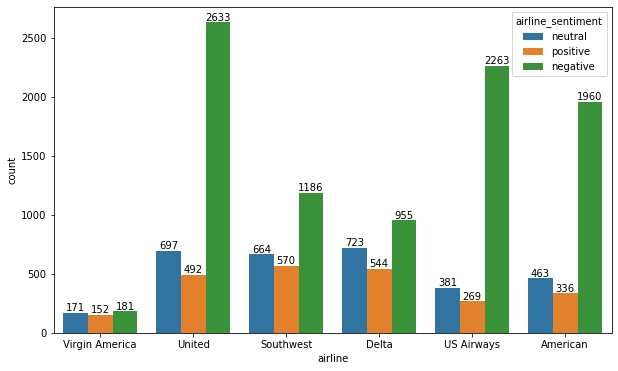

In [19]:
ax = sns.countplot(data = df, x ="airline", hue = "airline_sentiment")
for p in ax.containers:
    ax.bar_label(p)

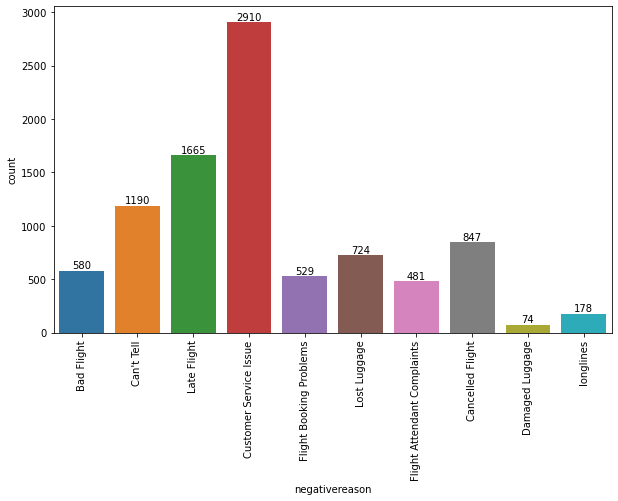

In [20]:
ax = sns.countplot(data =df, x ="negativereason")
ax.bar_label(ax.containers[0])
plt.xticks(rotation =90);

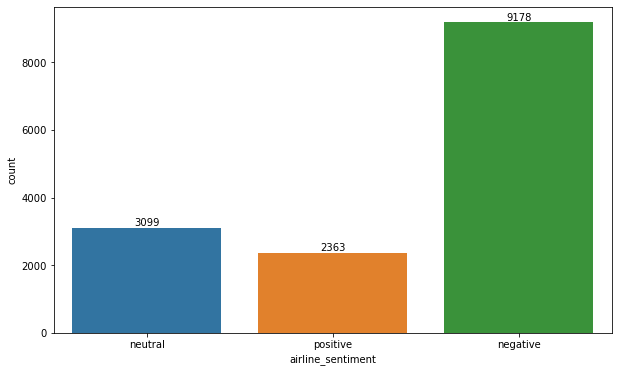

In [21]:
ax = sns.countplot(data =df, x = "airline_sentiment")
ax.bar_label(ax.containers[0]);

In [22]:
df["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

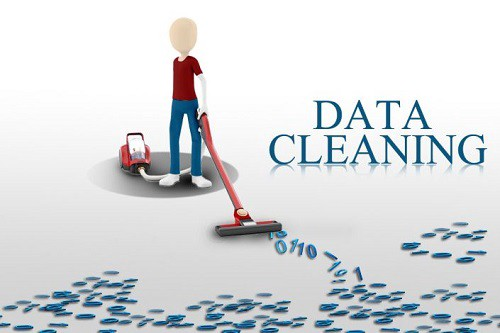

## Cleaning Data

In [23]:
df2 = df.copy()

In [24]:
df2["text"].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

## Cleaning Data

In [25]:
import re  #regulr expression
s = "http\\:www.mynet.com #lateflight @airlines"
s = re.sub("http\S+", "", s).strip()          #http den sonra boşluk haricindekileri temizle  ("") getir..adres olan yeri, '' ile degistiriyor,ve busekilde otomatikmen silinmis oluyor
s                                             #strip ile başındaki ve sonundaki boşlukları temizler

#   "http\S+" bu sekilde \S+   yazim sekli galiba bundan sonra bosluk isaretine kadar olan yeri yakala demek
# "#\S+"   buda # ile baslayan ve bosluk isaretine kadar olan yeri al demektir

'#lateflight @airlines'

In [26]:
s = re.sub("#\S+", "", s)                    #ile başlayan ifadeyi temizle
s

' @airlines'

In [27]:
s = re.sub("@\S+", "", s)
s.strip()

''

In [28]:
nltk.download('stopwords')

In [29]:
nltk.download('wordnet')

In [30]:
stop_words = stopwords.words('english')

for i in ["not", "no"]:       # sentiment analizde "not" ve "no" stop_wordden çıkarırız.cünkü bize lazim onlar,normalde bunlar stopwordde var
        stop_words.remove(i)

In [31]:
def cleaning(data):
    
    import re
    
    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()
    # bununlar icinde adres satirlari olanlari cikariyoruz

    #2. Removing Tags  #bu sekilde icinde #tags yani # ile baslayanlari siliyor
    data = re.sub('#\S+', '', data).strip()#data icinde # ile baslayanlari '' ile degistir yani sil diyoruz

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()
    
    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")    #don't gibi ifadeleri ' dan kurtarmış oluyoruz.
    
    #5. Tokenize
    text_tokens = word_tokenize(data.lower())  #datayi kücük harflerine cevirip tokenlarina ayiriyor
    
    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]  # kelimeleri aliyor, icinde bosluk olmayanlari
    
    #7. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]  #stopword olmayanlari aliyoruz
    
    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]  #bu sekilde kelimenin köklerini yakalamis oluyoruz,
    
    #joining
    return " ".join(text_cleaned)  #ve en son ayri ayri olan temizlenmis kelimeleri tekrar tweetler halina getiriyor

In [33]:
cleaning_text = df2["text"].apply(cleaning)       #cleaning fonksiyonumu apply ile tüm text ime uyguluyorum
cleaning_text[0:50]

0                                                  said
1          plus youve added commercial experience tacky
2          didnt today must mean need take another trip
3     really aggressive blast obnoxious entertainmen...
4                                  really big bad thing
5     seriously would pay flight seat didnt playing ...
6         yes nearly every time fly vx ear worm go away
7     really missed prime opportunity men without ha...
8                                                  well
9                 amazing arrived hour early youre good
10    know suicide second leading cause death among ...
11    lt pretty graphic much better minimal iconography
12    great deal already thinking trip amp havent ev...
13                     im flying sky u take away travel
14                                               thanks
15                                   schedule still mia
16    excited first cross country flight lax mco ive...
17    flew nyc sfo last week couldnt fully sit s

## Features and Label

In [153]:
df2 =df2[["airline_sentiment", "text"]]
df2.head()

#temizlenmiz text datasini sentiment features ile birlestirip yeni bir data seti yapti

airline_sentiment                                               text
0           neutral                @VirginAmerica What @dhepburn said.
1          positive  @VirginAmerica plus you've added commercials t...
2           neutral  @VirginAmerica I didn't today... Must mean I n...
3          negative  @VirginAmerica it's really aggressive to blast...
4          negative  @VirginAmerica and it's a really big bad thing...

## Train Test Split

In [154]:
from sklearn.model_selection import train_test_split

In [155]:
X = df2["text"]  #buda features oldu
y= df2["airline_sentiment"] #bu target oldu

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

#asagida modele koymak icin bu sekilde train test ile ayiriyoruz

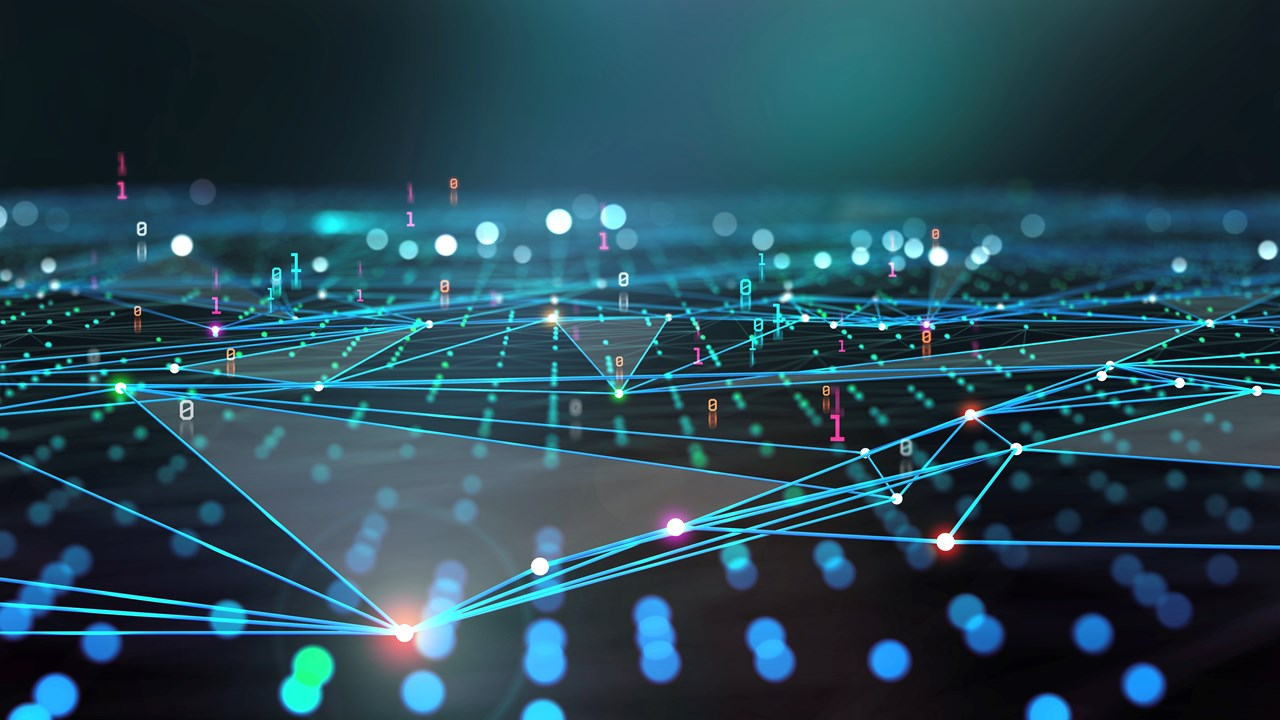

## Vectorization

In [157]:
from sklearn.feature_extraction.text import CountVectorizer

In [158]:
vectorizer = CountVectorizer(preprocessor=cleaning, min_df=3) # min_df= 3 (Corpus umda 3 ya da daha az olanları ignore et)
X_train_count = vectorizer.fit_transform(X_train)          #ngram_range=(1,2)
X_test_count = vectorizer.transform(X_test)          #max_features=1500 (benim corpusumda en çok kullanılan ilk 1500)

#burasi scaling kismina benziyor,islemin baslangic noktasi burasi
# cleaning ile temizleniyor ama galiba zaten yukarida temizlemistik
#burda Countvectoriezer kullaniyoruz
#preporssesing cleaning dedik
#bir cok token olacagindan 3 veya asagisini degerlendirme diyourz min_df de
# max degeride secebilirsin

#asagida birde TF-IDF olarak verebiliriz

In [159]:
X_train_count.toarray()

#arraye cevirdik

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [160]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names())
#dataframe ceviriyoruz
#hepsinin sifir gözükmesi burda kelimelerin fazla olmasindan dolayi oluyorfeatures sayisinin fazla olmasindan dolayi oluyor

aa  aadvantage  abc  ability  able  aboard  abq  absolute  absolutely  \
0       0           0    0        0     0       0    0         0           0   
1       0           0    0        0     0       0    0         0           0   
2       0           0    0        0     0       0    0         0           0   
3       0           0    0        0     0       0    0         0           0   
4       0           0    0        0     0       0    0         0           0   
...    ..         ...  ...      ...   ...     ...  ...       ...         ...   
11707   0           0    0        0     0       0    0         0           0   
11708   0           0    0        0     0       0    0         0           0   
11709   0           0    0        0     0       0    0         0           0   
11710   0           0    0        0     0       0    0         0           0   
11711   1           0    0        0     0       0    0         0           0   

       absurd  abt  abysmal  ac  accept  acceptable  accepted  accepting  \
0           0    0        0   0       0           0         0          0   
1           0    0        0   0       0           0         0          0   
2           0    0        0   0       0           0         0          0   
3           0    0        0   0       0           0         0          0   
4           0    0        0   0       0           0         0          0   
...       ...  ...      ...  ..     ...         ...       ...        ...   
11707       0    0        0   0       0           0         0          0   
11708       0    0        0   0       0           0         0          0   
11709       0    0        0   0       0           0         0          0   
11710       0    0        0   0       0           0         0          0   
11711       0    0        0   0       0           0         0          0   

       access  accident  accommodate  accommodating  accommodation  \
0           0         0            0              0              0   
1           0         0            0              0              0   
2           0         0            0              0              0   
3           0         0            0              0              0   
4           0         0            0              0              0   
...       ...       ...          ...            ...            ...   
11707       0         0            0              0              0   
11708       0         0            0              0              0   
11709       0         0            0              0              0   
11710       0         0            0              0              0   
11711       0         0            0              0              0   

       accomplished  according  accordingly  ...  yea  yeah  year  yell  \
0                 0          0            0  ...    0     0     0     0   
1                 0          0            0  ...    0     0     0     0   
2                 0          0            0  ...    0     0     0     0   
3                 0          0            0  ...    0     0     0     0   
4                 0          0            0  ...    0     0     0     0   
...             ...        ...          ...  ...  ...   ...   ...   ...   
11707             0          0            0  ...    0     0     0     0   
11708             0          0            0  ...    0     0     0     0   
11709             0          0            0  ...    0     0     0     0   
11710             0          0            0  ...    0     0     0     0   
11711             0          0            0  ...    0     0     0     0   

       yelled  yelling  yep  yes  yest  yesterday  yet  yo  york  youd  youll  \
0           0        0    0    0     0          0    0   0     0     0      0   
1           0        0    0    0     0          0    0   0     0     0      0   
2           0        0    0    0     0          0    0   0     0     0      0   
3           0        0    0    0     0          0    0   0     0   

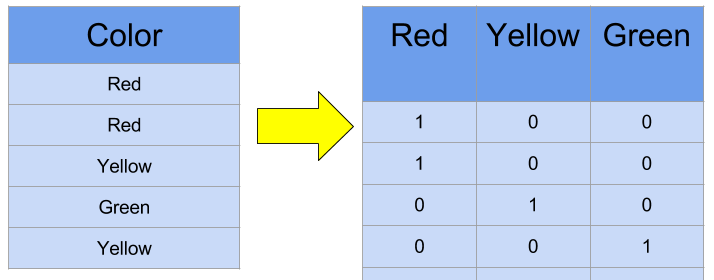

## Model Comparisons - Vectorization

In [162]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score

In [163]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(confusion_matrix(y_test, y_pred))
    print("Test_Set")
    print(classification_report(y_test,y_pred))
    print("Train_Set")
    print(classification_report(y_train,y_pred_train))

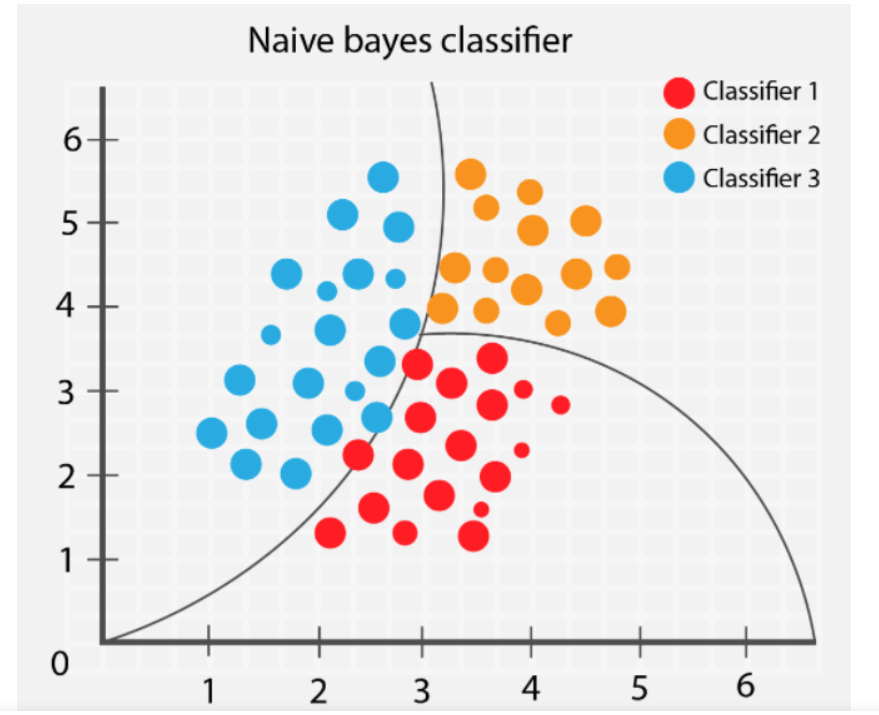

## Naive Bayes

In [164]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # BernoulliNB for binary model

In [165]:
nb = MultinomialNB(alpha=3)
nb.fit(X_train_count,y_train)
#ML deki fit islemi yapiliyor
#asagida da TF iDF yapiyoruz


MultinomialNB(alpha=3)

In [166]:
print("NB MODEL")
eval(nb, X_train_count, X_test_count)

NB MODEL
[[1705   86   44]
 [ 336  239   45]
 [ 138   35  300]]
Test_Set
              precision    recall  f1-score   support

    negative       0.78      0.93      0.85      1835
     neutral       0.66      0.39      0.49       620
    positive       0.77      0.63      0.70       473

    accuracy                           0.77      2928
   macro avg       0.74      0.65      0.68      2928
weighted avg       0.76      0.77      0.75      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.81      0.94      0.87      7343
     neutral       0.76      0.49      0.59      2479
    positive       0.81      0.68      0.74      1890

    accuracy                           0.80     11712
   macro avg       0.79      0.70      0.73     11712
weighted avg       0.80      0.80      0.79     11712



In [167]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
scoring = {'accuracy': make_scorer(accuracy_score),
            'precision-neg': make_scorer(precision_score, average=None, labels=["negative"]), #aslinda burda negative göre aliniyordu,biz ML de negative zaten büyük cikiyor en düsüge göre aliyoruduk, en düsük iyilesirse zaten hepsi iyilesir diye
            'recall-neg': make_scorer(recall_score, average=None, labels = ["negative"]),
            'f1-neg': make_scorer(f1_score, average=None, labels = ["negative"])}

model = MultinomialNB(alpha=3)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]


#bu scorng asagidaki modellerdede parametre olarak kullanilacak

test_accuracy         0.754439
test_precision-neg    0.775536
test_recall-neg       0.923326
test_f1-neg           0.842967
dtype: float64

In [168]:
!pip install yellowbrick

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve

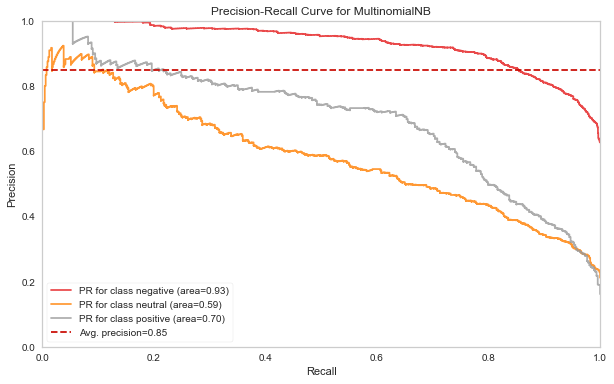

In [169]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
    MultinomialNB(alpha=3),
    classes=nb.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [170]:
y_pred = nb.predict(X_test_count)
nb_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_AP_neg = viz.score_["negative"]

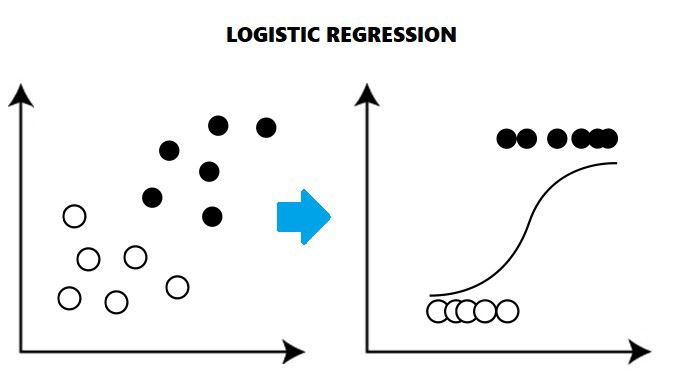

## Logistic Regression

In [ ]:
#burda model kurulmus ama GridSearch ile en yii parametreler bulunmamis ve belki threshold kullanilmasida iyi olabilir

In [171]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C = 0.02, max_iter=1000) #class_weight='balanced'
log.fit(X_train_count,y_train)

LogisticRegression(C=0.02, max_iter=1000)

In [172]:
print("LOG MODEL")
eval(log, X_train_count, X_test_count)

LOG MODEL
[[1759   40   36]
 [ 366  211   43]
 [ 177   47  249]]
Test_Set
              precision    recall  f1-score   support

    negative       0.76      0.96      0.85      1835
     neutral       0.71      0.34      0.46       620
    positive       0.76      0.53      0.62       473

    accuracy                           0.76      2928
   macro avg       0.74      0.61      0.64      2928
weighted avg       0.75      0.76      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.77      0.97      0.86      7343
     neutral       0.76      0.41      0.53      2479
    positive       0.79      0.51      0.62      1890

    accuracy                           0.77     11712
   macro avg       0.77      0.63      0.67     11712
weighted avg       0.77      0.77      0.75     11712



In [173]:
# model = LogisticRegression(C = 0.02, max_iter=1000) eger optimum parametreler ile model kurmmussak bunu yazmaya gerek yok,aslinda yukarda modleimiz oldugu iicn hic gerek yok
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.745731
test_precision-neg    0.747621
test_recall-neg       0.963501
test_f1-neg           0.841924
dtype: float64

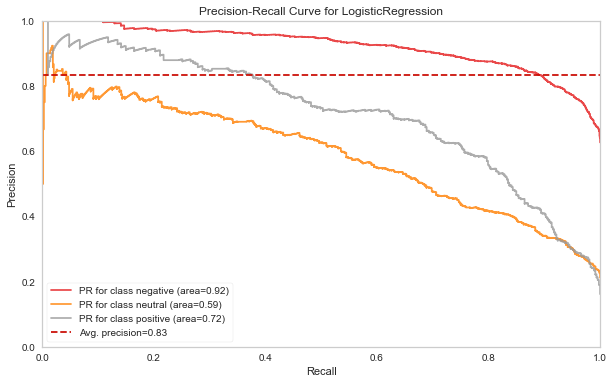

In [174]:
viz = PrecisionRecallCurve(
    LogisticRegression(C = 0.02, max_iter=1000),
    classes=log.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [175]:
y_pred = log.predict(X_test_count)
log_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_AP_neg = viz.score_["negative"]

In [176]:
log = LogisticRegression(C = 0.02, max_iter=1000, class_weight='balanced')
log.fit(X_train_count,y_train)

LogisticRegression(C=0.02, class_weight='balanced', max_iter=1000)

In [177]:
print("LOG MODEL BALANCED")
eval(log, X_train_count, X_test_count)

LOG MODEL BALANCED
[[1302  435   98]
 [  98  447   75]
 [  34   96  343]]
Test_Set
              precision    recall  f1-score   support

    negative       0.91      0.71      0.80      1835
     neutral       0.46      0.72      0.56       620
    positive       0.66      0.73      0.69       473

    accuracy                           0.71      2928
   macro avg       0.68      0.72      0.68      2928
weighted avg       0.77      0.71      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.93      0.74      0.82      7343
     neutral       0.51      0.78      0.62      2479
    positive       0.67      0.75      0.71      1890

    accuracy                           0.75     11712
   macro avg       0.70      0.75      0.72     11712
weighted avg       0.80      0.75      0.76     11712



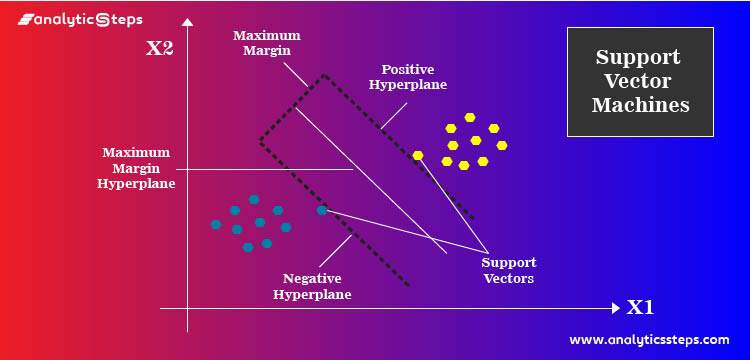

## SVM

In [178]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01)
svc.fit(X_train_count,y_train)

LinearSVC(C=0.01)

In [179]:
print("SVC MODEL")
eval(svc, X_train_count, X_test_count)

SVC MODEL
[[1711   80   44]
 [ 291  279   50]
 [ 124   50  299]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1835
     neutral       0.68      0.45      0.54       620
    positive       0.76      0.63      0.69       473

    accuracy                           0.78      2928
   macro avg       0.75      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.83      0.95      0.89      7343
     neutral       0.76      0.55      0.64      2479
    positive       0.80      0.63      0.70      1890

    accuracy                           0.82     11712
   macro avg       0.80      0.71      0.74     11712
weighted avg       0.81      0.82      0.81     11712



In [180]:
model = LinearSVC(C=0.01)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.777494
test_precision-neg    0.799702
test_recall-neg       0.939396
test_f1-neg           0.863922
dtype: float64

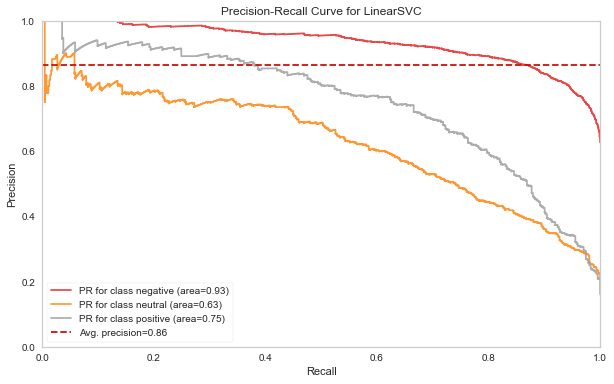

In [181]:
viz = PrecisionRecallCurve(
    LinearSVC(C=0.01),
    classes=svc.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [182]:
y_pred = svc.predict(X_test_count)
svc_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_AP_neg = viz.score_["negative"]

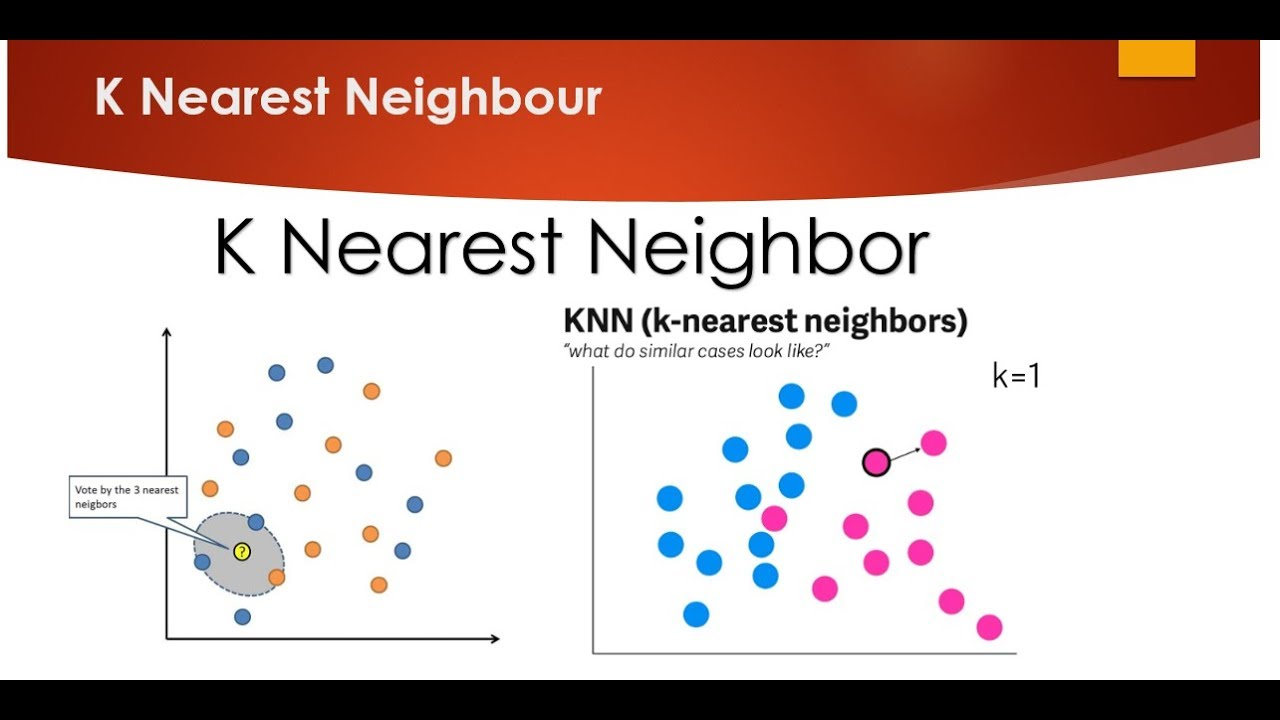

## KNN

In [183]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_count,y_train)

KNeighborsClassifier(n_neighbors=7)

In [184]:
print("KNN MODEL")
eval(knn, X_train_count, X_test_count)

KNN MODEL
[[912 839  84]
 [113 447  60]
 [ 46 178 249]]
Test_Set
              precision    recall  f1-score   support

    negative       0.85      0.50      0.63      1835
     neutral       0.31      0.72      0.43       620
    positive       0.63      0.53      0.58       473

    accuracy                           0.55      2928
   macro avg       0.60      0.58      0.54      2928
weighted avg       0.70      0.55      0.58      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.90      0.62      0.73      7343
     neutral       0.39      0.82      0.53      2479
    positive       0.70      0.56      0.62      1890

    accuracy                           0.65     11712
   macro avg       0.66      0.66      0.63     11712
weighted avg       0.76      0.65      0.67     11712



In [185]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.530654
test_precision-neg    0.846802
test_recall-neg       0.466436
test_f1-neg           0.601124
dtype: float64

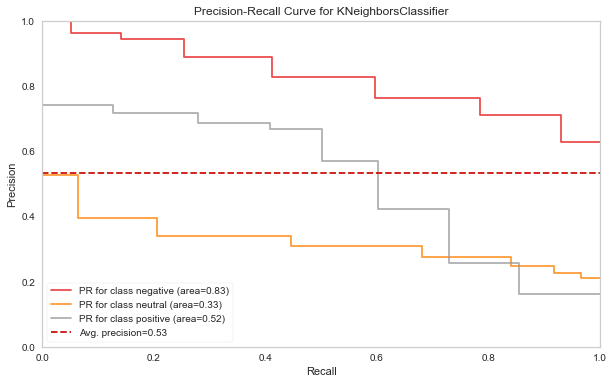

In [186]:
viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [187]:
y_pred = knn.predict(X_test_count)
knn_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_AP_neg = viz.score_["negative"]

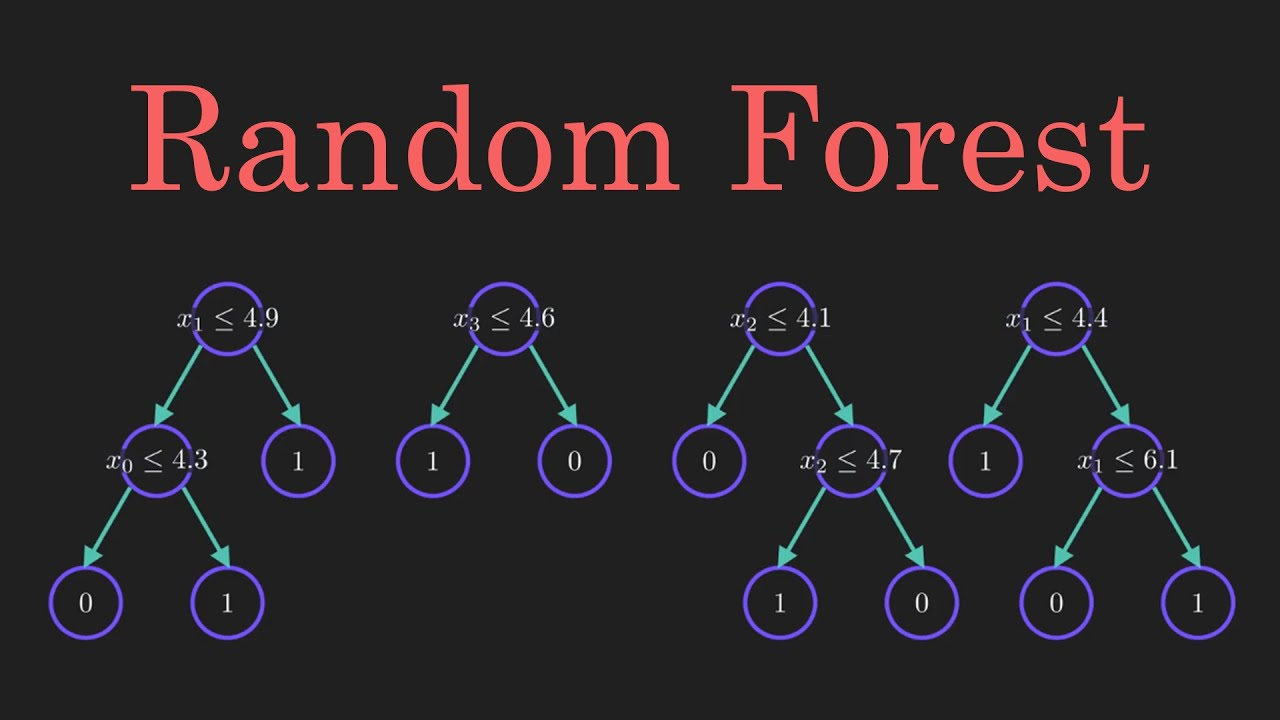

## Random Forest

In [188]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1) # class_weight="balanced"
rf.fit(X_train_count, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [189]:
print("RF MODEL")
eval(rf, X_train_count, X_test_count)

RF MODEL
[[1798   11   26]
 [ 523   59   38]
 [ 219    7  247]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.98      0.82      1835
     neutral       0.77      0.10      0.17       620
    positive       0.79      0.52      0.63       473

    accuracy                           0.72      2928
   macro avg       0.76      0.53      0.54      2928
weighted avg       0.73      0.72      0.65      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.74      1.00      0.85      7343
     neutral       0.97      0.20      0.34      2479
    positive       0.92      0.63      0.75      1890

    accuracy                           0.77     11712
   macro avg       0.88      0.61      0.64     11712
weighted avg       0.82      0.77      0.72     11712



In [190]:
model = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.710040
test_precision-neg    0.698911
test_recall-neg       0.984338
test_f1-neg           0.817418
dtype: float64

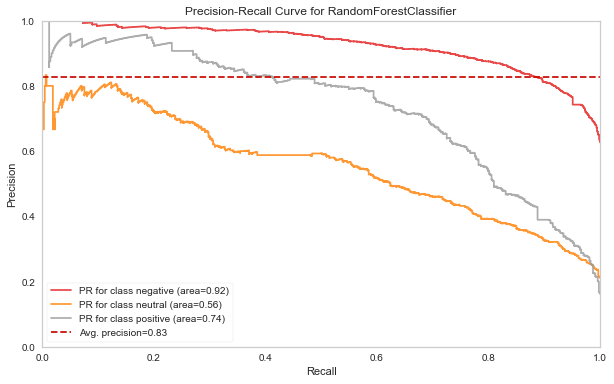

In [191]:
viz = PrecisionRecallCurve(
    RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1),
    classes=rf.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [192]:
y_pred = rf.predict(X_test_count)
rf_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_AP_neg = viz.score_["negative"]

In [193]:
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_count, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=40, n_jobs=-1,
                       random_state=42)

In [194]:
print("RF MODEL BALANCED")
eval(rf, X_train_count, X_test_count)

RF MODEL BALANCED
[[1455  305   75]
 [ 152  403   65]
 [  53   97  323]]
Test_Set
              precision    recall  f1-score   support

    negative       0.88      0.79      0.83      1835
     neutral       0.50      0.65      0.57       620
    positive       0.70      0.68      0.69       473

    accuracy                           0.74      2928
   macro avg       0.69      0.71      0.70      2928
weighted avg       0.77      0.74      0.75      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.97      0.85      0.91      7343
     neutral       0.64      0.90      0.75      2479
    positive       0.87      0.82      0.85      1890

    accuracy                           0.86     11712
   macro avg       0.83      0.86      0.83     11712
weighted avg       0.89      0.86      0.86     11712



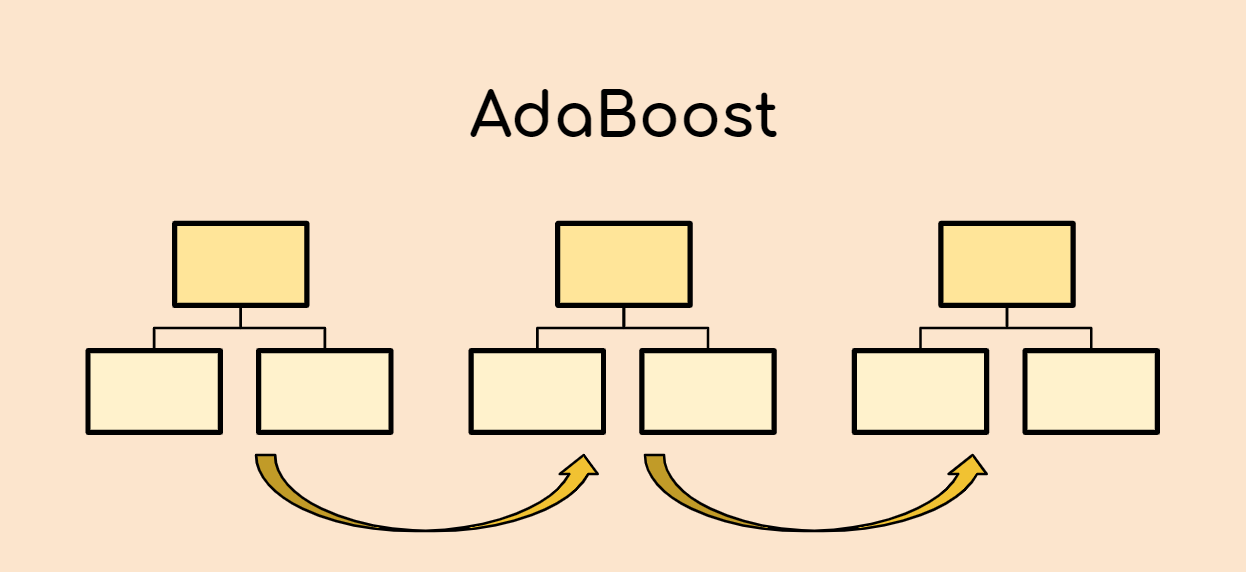

## Ada Boost

In [195]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_count, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [196]:
print("Ada MODEL")
eval(ada, X_train_count, X_test_count)

Ada MODEL
[[1555  205   75]
 [ 210  339   71]
 [  86   72  315]]
Test_Set
              precision    recall  f1-score   support

    negative       0.84      0.85      0.84      1835
     neutral       0.55      0.55      0.55       620
    positive       0.68      0.67      0.67       473

    accuracy                           0.75      2928
   macro avg       0.69      0.69      0.69      2928
weighted avg       0.75      0.75      0.75      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.87      0.88      0.87      7343
     neutral       0.61      0.62      0.62      2479
    positive       0.79      0.71      0.75      1890

    accuracy                           0.80     11712
   macro avg       0.75      0.74      0.75     11712
weighted avg       0.80      0.80      0.80     11712



In [197]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.759136
test_precision-neg    0.842861
test_recall-neg       0.856597
test_f1-neg           0.849649
dtype: float64

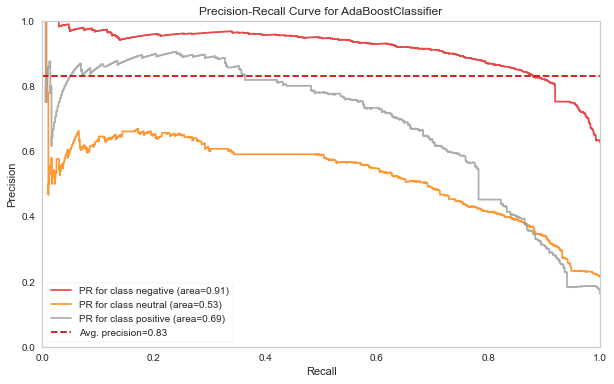

In [198]:
viz = PrecisionRecallCurve(
    AdaBoostClassifier(n_estimators= 500, random_state = 42),
    classes=ada.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [199]:
y_pred = ada.predict(X_test_count)
ada_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_AP_neg = viz.score_["negative"]

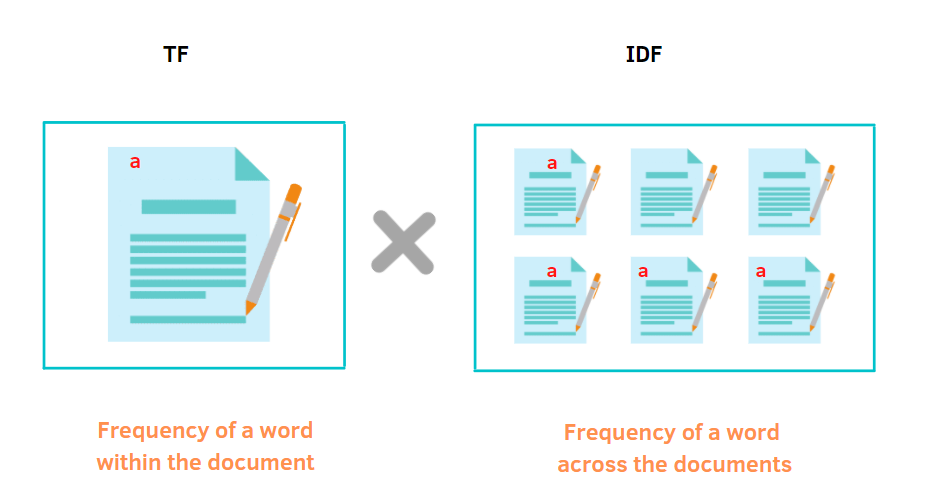

## TF-IDF

In [200]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [201]:
tf_idf_vectorizer = TfidfVectorizer(preprocessor=cleaning, min_df=3)
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [202]:
X_train_tf_idf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.32545156, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [203]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names_out())

aa  aadvantage  abc  ability  able  aboard  abq  absolute  \
0      0.000000         0.0  0.0      0.0   0.0     0.0  0.0       0.0   
1      0.000000         0.0  0.0      0.0   0.0     0.0  0.0       0.0   
2      0.000000         0.0  0.0      0.0   0.0     0.0  0.0       0.0   
3      0.000000         0.0  0.0      0.0   0.0     0.0  0.0       0.0   
4      0.000000         0.0  0.0      0.0   0.0     0.0  0.0       0.0   
...         ...         ...  ...      ...   ...     ...  ...       ...   
11707  0.000000         0.0  0.0      0.0   0.0     0.0  0.0       0.0   
11708  0.000000         0.0  0.0      0.0   0.0     0.0  0.0       0.0   
11709  0.000000         0.0  0.0      0.0   0.0     0.0  0.0       0.0   
11710  0.000000         0.0  0.0      0.0   0.0     0.0  0.0       0.0   
11711  0.325452         0.0  0.0      0.0   0.0     0.0  0.0       0.0   

       absolutely  absurd  abt  abysmal   ac  accept  acceptable  accepted  \
0             0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   
1             0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   
2             0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   
3             0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   
4             0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   
...           ...     ...  ...      ...  ...     ...         ...       ...   
11707         0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   
11708         0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   
11709         0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   
11710         0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   
11711         0.0     0.0  0.0      0.0  0.0     0.0         0.0       0.0   

       accepting  access  accident  accommodate  accommodating  accommodation  \
0            0.0     0.0       0.0          0.0            0.0            0.0   
1            0.0     0.0       0.0          0.0            0.0            0.0   
2            0.0     0.0       0.0          0.0            0.0            0.0   
3            0.0     0.0       0.0          0.0            0.0            0.0   
4            0.0     0.0       0.0          0.0            0.0            0.0   
...          ...     ...       ...          ...            ...            ...   
11707        0.0     0.0       0.0          0.0            0.0            0.0   
11708        0.0     0.0       0.0          0.0            0.0            0.0   
11709        0.0     0.0       0.0          0.0            0.0            0.0   
11710        0.0     0.0       0.0          0.0            0.0            0.0   
11711        0.0     0.0       0.0          0.0            0.0            0.0   

       accomplished  according  accordingly  ...  yea  yeah  year  yell  \
0               0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   
1               0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   
2               0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   
3               0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   
4               0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   
...             ...        ...          ...  ...  ...   ...   ...   ...   
11707           0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   
11708           0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   
11709           0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   
11710           0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   
11711           0.0        0.0          0.0  ...  0.0   0.0   0.0   0.0   

       yelled  yelling  yep  yes  yest  yesterday  yet   yo  york  youd  \
0         0.0      0.0  0.0  0.0   0.0        0.0  0.0  0.0   0.0   0.0   
1         0.0      0.0  0.0  0.0   0.0        0.0  0.0  0.0   0.0   0.0   
2         0.0      0.0  0.0  0.0   0.0        0.0  0.0  0.0   0.0   0.0   
3         0.0

## Model Comparisons  TF-IDF

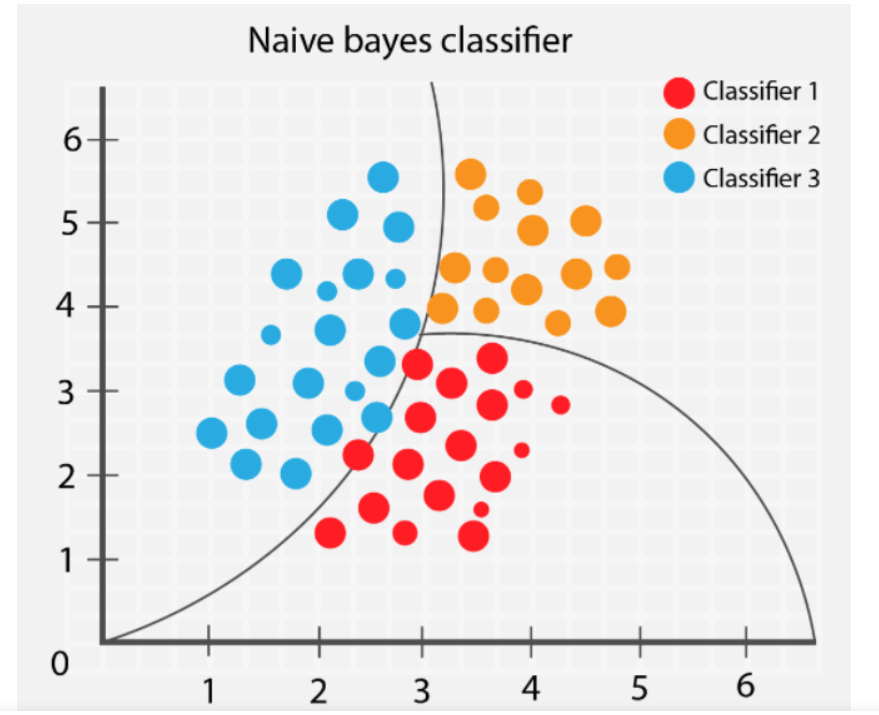

## Naive Bayes

In [204]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
nb = MultinomialNB()
nb.fit(X_train_tf_idf,y_train)

MultinomialNB()

In [205]:
print("NB MODEL")
eval(nb, X_train_tf_idf, X_test_tf_idf)

NB MODEL
[[1802   25    8]
 [ 426  172   22]
 [ 248   31  194]]
Test_Set
              precision    recall  f1-score   support

    negative       0.73      0.98      0.84      1835
     neutral       0.75      0.28      0.41       620
    positive       0.87      0.41      0.56       473

    accuracy                           0.74      2928
   macro avg       0.78      0.56      0.60      2928
weighted avg       0.76      0.74      0.70      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.75      0.99      0.85      7343
     neutral       0.84      0.35      0.50      2479
    positive       0.91      0.51      0.65      1890

    accuracy                           0.78     11712
   macro avg       0.84      0.62      0.67     11712
weighted avg       0.80      0.78      0.75     11712



In [206]:
model = MultinomialNB()
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.731643
test_precision-neg    0.721593
test_recall-neg       0.978890
test_f1-neg           0.830756
dtype: float64

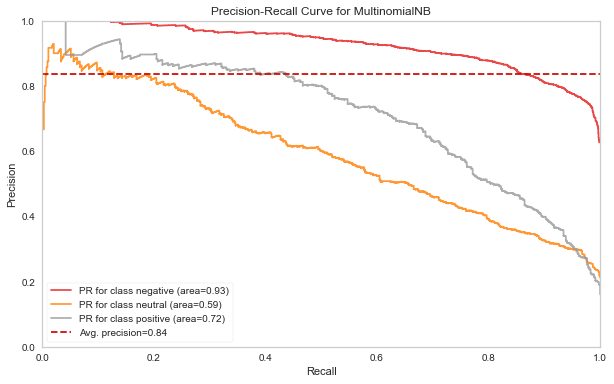

In [207]:
viz = PrecisionRecallCurve(
    MultinomialNB(),
    classes=nb.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [208]:
y_pred = nb.predict(X_test_tf_idf)
nb_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_AP_neg = viz.score_["negative"]

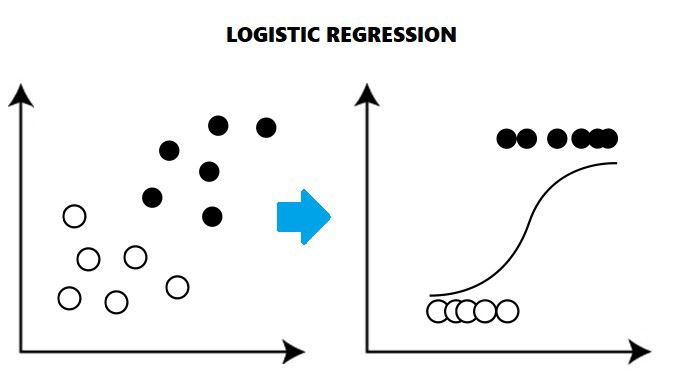

## Logistic Regression

In [209]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=0.4, max_iter=1000)
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, max_iter=1000)

In [210]:
print("LOG MODEL")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL
[[1757   51   27]
 [ 332  256   32]
 [ 144   47  282]]
Test_Set
              precision    recall  f1-score   support

    negative       0.79      0.96      0.86      1835
     neutral       0.72      0.41      0.53       620
    positive       0.83      0.60      0.69       473

    accuracy                           0.78      2928
   macro avg       0.78      0.66      0.69      2928
weighted avg       0.78      0.78      0.76      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.82      0.97      0.89      7343
     neutral       0.82      0.53      0.64      2479
    positive       0.87      0.62      0.73      1890

    accuracy                           0.82     11712
   macro avg       0.84      0.71      0.75     11712
weighted avg       0.83      0.82      0.81     11712



In [211]:
model = LogisticRegression(C=0.4, max_iter=1000)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.771432
test_precision-neg    0.776135
test_recall-neg       0.960506
test_f1-neg           0.858515
dtype: float64

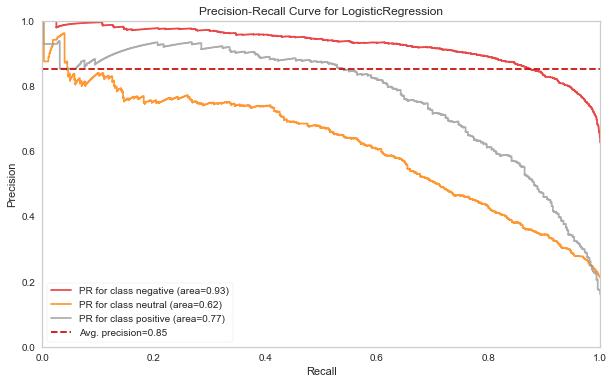

In [212]:
viz = PrecisionRecallCurve(
    LogisticRegression(C=0.4, max_iter=1000),
    classes=log.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [213]:
y_pred = log.predict(X_test_tf_idf)
log_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_AP_neg = viz.score_["negative"]

In [214]:
log = LogisticRegression(C=0.4, max_iter=1000, class_weight="balanced")
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, class_weight='balanced', max_iter=1000)

In [215]:
print("LOG MODEL BALANCED")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL BALANCED
[[1432  304   99]
 [ 121  427   72]
 [  39   71  363]]
Test_Set
              precision    recall  f1-score   support

    negative       0.90      0.78      0.84      1835
     neutral       0.53      0.69      0.60       620
    positive       0.68      0.77      0.72       473

    accuracy                           0.76      2928
   macro avg       0.70      0.75      0.72      2928
weighted avg       0.79      0.76      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.94      0.81      0.87      7343
     neutral       0.61      0.80      0.69      2479
    positive       0.74      0.84      0.79      1890

    accuracy                           0.81     11712
   macro avg       0.76      0.82      0.78     11712
weighted avg       0.84      0.81      0.82     11712



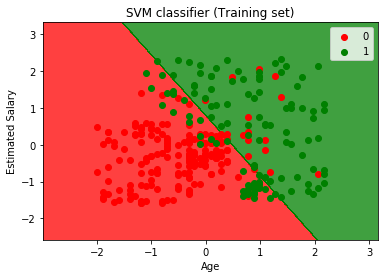

## SVM

In [216]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.1)
svc.fit(X_train_tf_idf,y_train)

LinearSVC(C=0.1)

In [217]:
print("SVC MODEL")
eval(svc, X_train_tf_idf, X_test_tf_idf)

SVC MODEL
[[1737   64   34]
 [ 312  263   45]
 [ 124   44  305]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87      1835
     neutral       0.71      0.42      0.53       620
    positive       0.79      0.64      0.71       473

    accuracy                           0.79      2928
   macro avg       0.77      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.84      0.97      0.90      7343
     neutral       0.83      0.56      0.67      2479
    positive       0.87      0.68      0.76      1890

    accuracy                           0.84     11712
   macro avg       0.84      0.74      0.78     11712
weighted avg       0.84      0.84      0.83     11712



In [218]:
model = LinearSVC(C=0.1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.781934
test_precision-neg    0.790352
test_recall-neg       0.956965
test_f1-neg           0.865677
dtype: float64

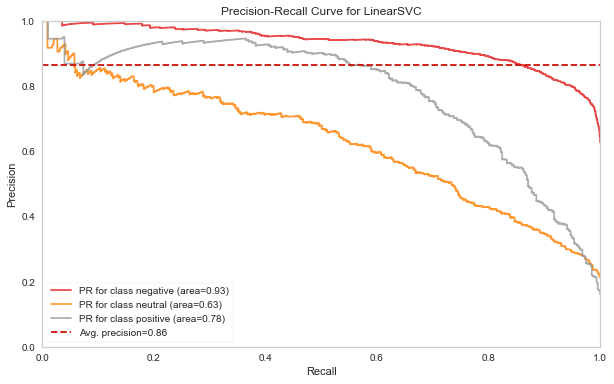

In [219]:
viz = PrecisionRecallCurve(
    LinearSVC(C=0.1),
    classes=svc.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [220]:
y_pred = svc.predict(X_test_tf_idf)
svc_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_AP_neg = viz.score_["negative"]

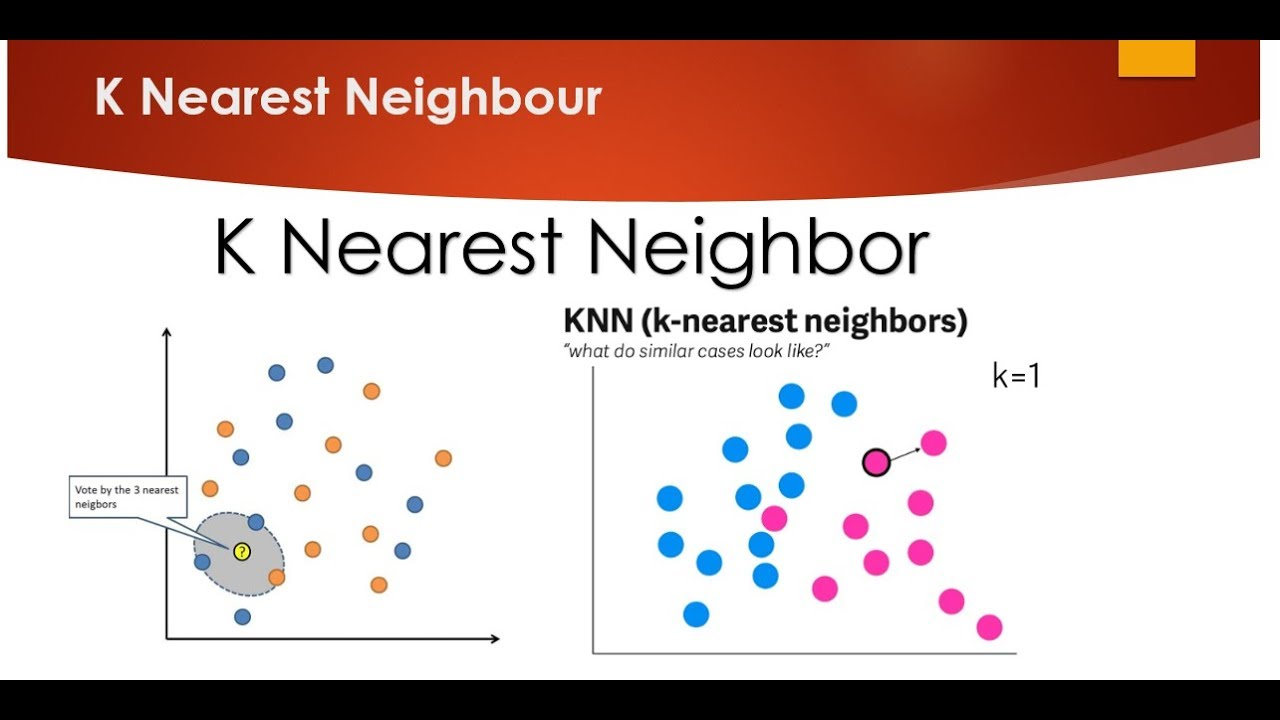

## KNN

In [221]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_tf_idf,y_train)

KNeighborsClassifier(n_neighbors=7)

In [222]:
print("KNN MODEL")
eval(knn, X_train_tf_idf, X_test_tf_idf)

KNN MODEL
[[ 259 1563   13]
 [  57  549   14]
 [  42  335   96]]
Test_Set
              precision    recall  f1-score   support

    negative       0.72      0.14      0.24      1835
     neutral       0.22      0.89      0.36       620
    positive       0.78      0.20      0.32       473

    accuracy                           0.31      2928
   macro avg       0.58      0.41      0.31      2928
weighted avg       0.63      0.31      0.28      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.87      0.28      0.43      7343
     neutral       0.26      0.92      0.41      2479
    positive       0.83      0.24      0.37      1890

    accuracy                           0.41     11712
   macro avg       0.65      0.48      0.40     11712
weighted avg       0.73      0.41      0.41     11712



In [223]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.302765
test_precision-neg    0.723823
test_recall-neg       0.139858
test_f1-neg           0.233937
dtype: float64

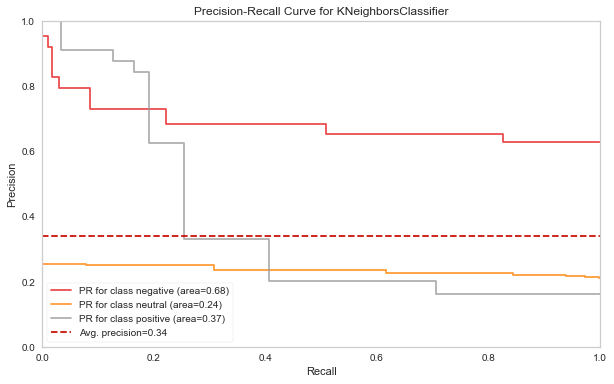

In [224]:
viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [225]:
y_pred = knn.predict(X_test_tf_idf)
knn_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_AP_neg = viz.score_["negative"]

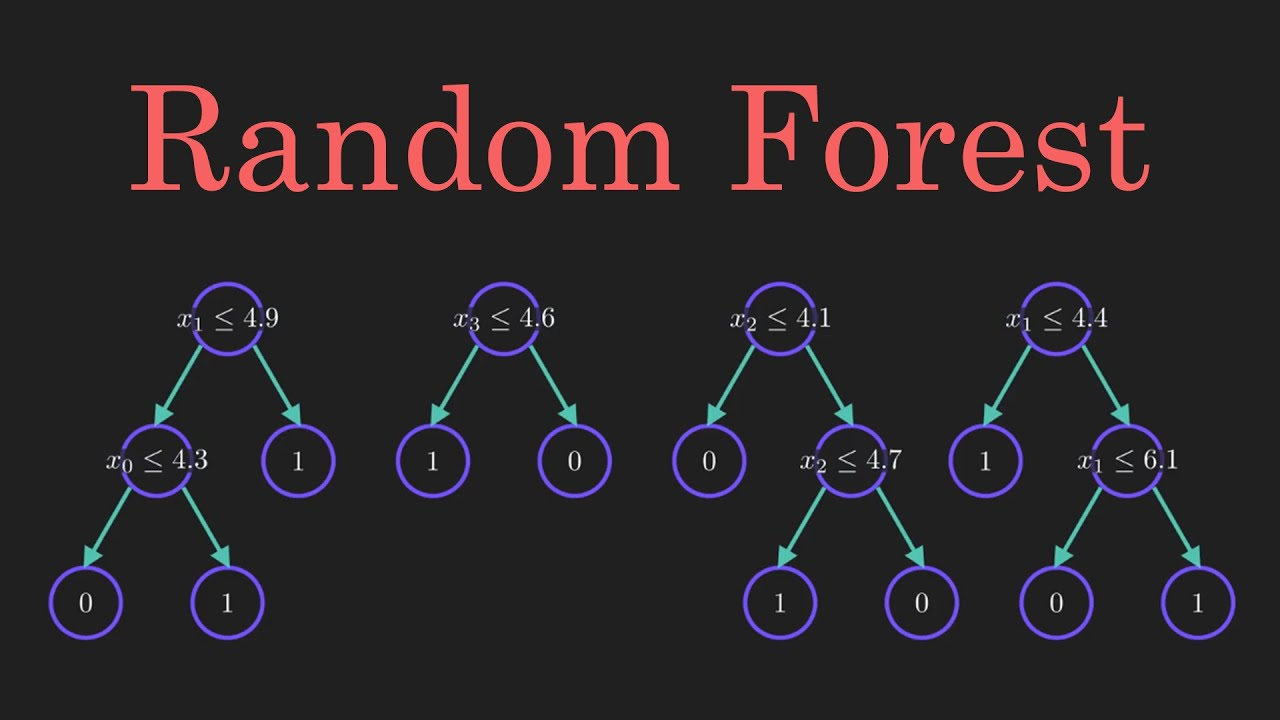

## RandomForest

In [226]:
rf = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [227]:
print("RF MODEL")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL
[[1805   10   20]
 [ 532   53   35]
 [ 242    7  224]]
Test_Set
              precision    recall  f1-score   support

    negative       0.70      0.98      0.82      1835
     neutral       0.76      0.09      0.15       620
    positive       0.80      0.47      0.60       473

    accuracy                           0.71      2928
   macro avg       0.75      0.51      0.52      2928
weighted avg       0.73      0.71      0.64      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.73      1.00      0.84      7343
     neutral       0.98      0.21      0.34      2479
    positive       0.94      0.58      0.72      1890

    accuracy                           0.76     11712
   macro avg       0.88      0.60      0.64     11712
weighted avg       0.82      0.76      0.72     11712



In [228]:
model = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.707565
test_precision-neg    0.694344
test_recall-neg       0.988288
test_f1-neg           0.815631
dtype: float64

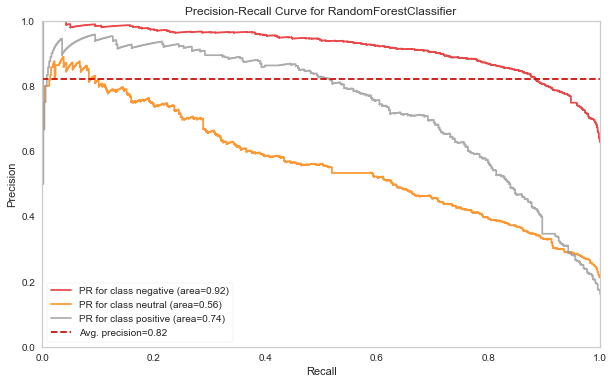

In [229]:
viz = PrecisionRecallCurve(
    RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1),
    classes=rf.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [230]:
y_pred = rf.predict(X_test_tf_idf)
rf_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_AP_neg = viz.score_["negative"]

In [231]:
rf = RandomForestClassifier(100, max_depth=15, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

In [232]:
print("RF MODEL BALANCED")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL BALANCED
[[1353  386   96]
 [ 129  423   68]
 [  47  108  318]]
Test_Set
              precision    recall  f1-score   support

    negative       0.88      0.74      0.80      1835
     neutral       0.46      0.68      0.55       620
    positive       0.66      0.67      0.67       473

    accuracy                           0.72      2928
   macro avg       0.67      0.70      0.67      2928
weighted avg       0.76      0.72      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.93      0.76      0.84      7343
     neutral       0.52      0.81      0.63      2479
    positive       0.74      0.72      0.73      1890

    accuracy                           0.77     11712
   macro avg       0.73      0.76      0.73     11712
weighted avg       0.81      0.77      0.78     11712



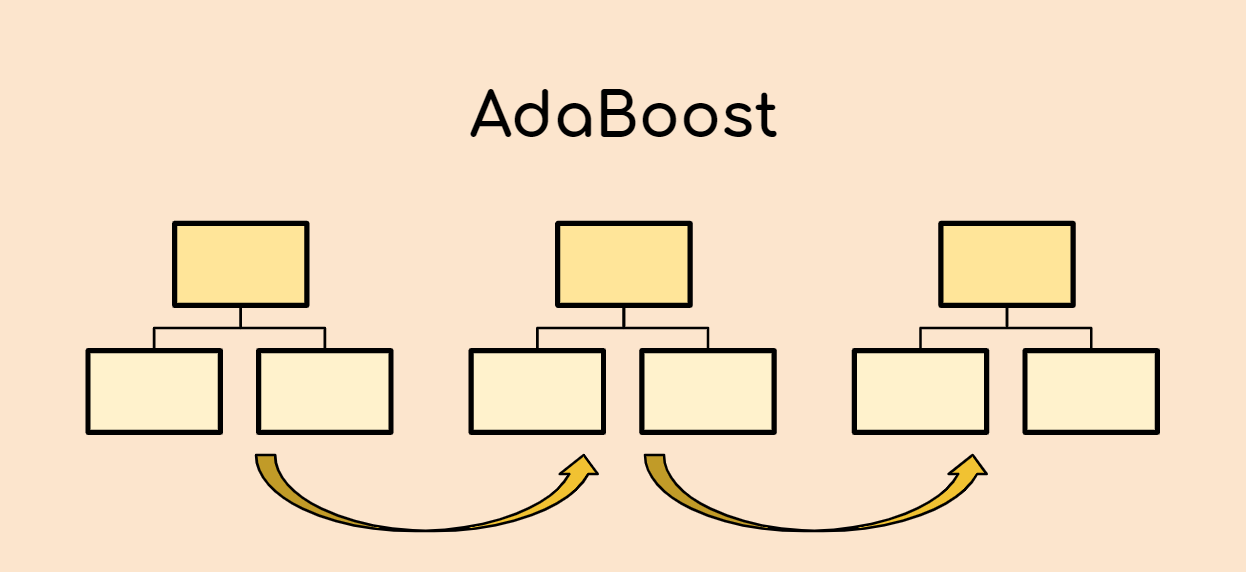

## Ada Boost

In [233]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_tf_idf, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [234]:
print("Ada MODEL")
eval(ada, X_train_tf_idf, X_test_tf_idf)

Ada MODEL
[[1536  226   73]
 [ 228  331   61]
 [  98   73  302]]
Test_Set
              precision    recall  f1-score   support

    negative       0.82      0.84      0.83      1835
     neutral       0.53      0.53      0.53       620
    positive       0.69      0.64      0.66       473

    accuracy                           0.74      2928
   macro avg       0.68      0.67      0.68      2928
weighted avg       0.74      0.74      0.74      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.85      0.88      0.87      7343
     neutral       0.62      0.62      0.62      2479
    positive       0.83      0.73      0.77      1890

    accuracy                           0.80     11712
   macro avg       0.77      0.74      0.75     11712
weighted avg       0.80      0.80      0.80     11712



In [235]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.739670
test_precision-neg    0.823314
test_recall-neg       0.843660
test_f1-neg           0.833311
dtype: float64

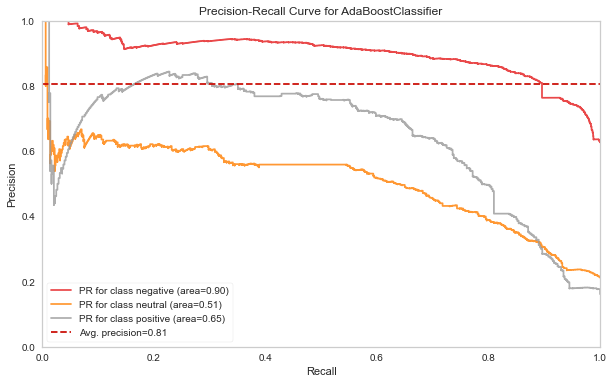

In [236]:
viz = PrecisionRecallCurve(
    AdaBoostClassifier(n_estimators= 500, random_state = 42),
    classes=ada.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [237]:
y_pred = ada.predict(X_test_tf_idf)
ada_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_AP_neg = viz.score_["negative"]

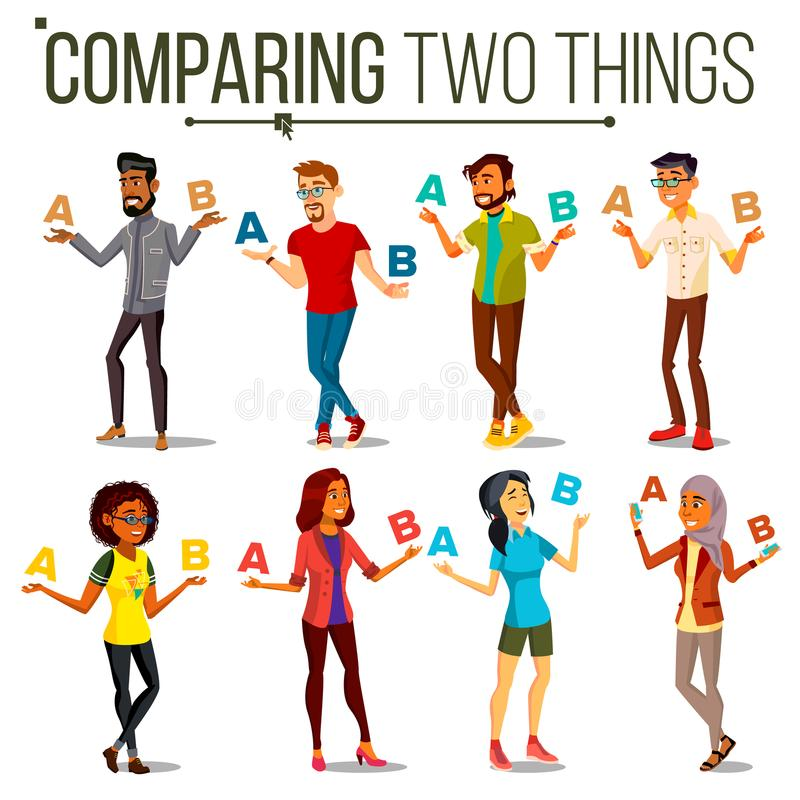

## Compare Scoring

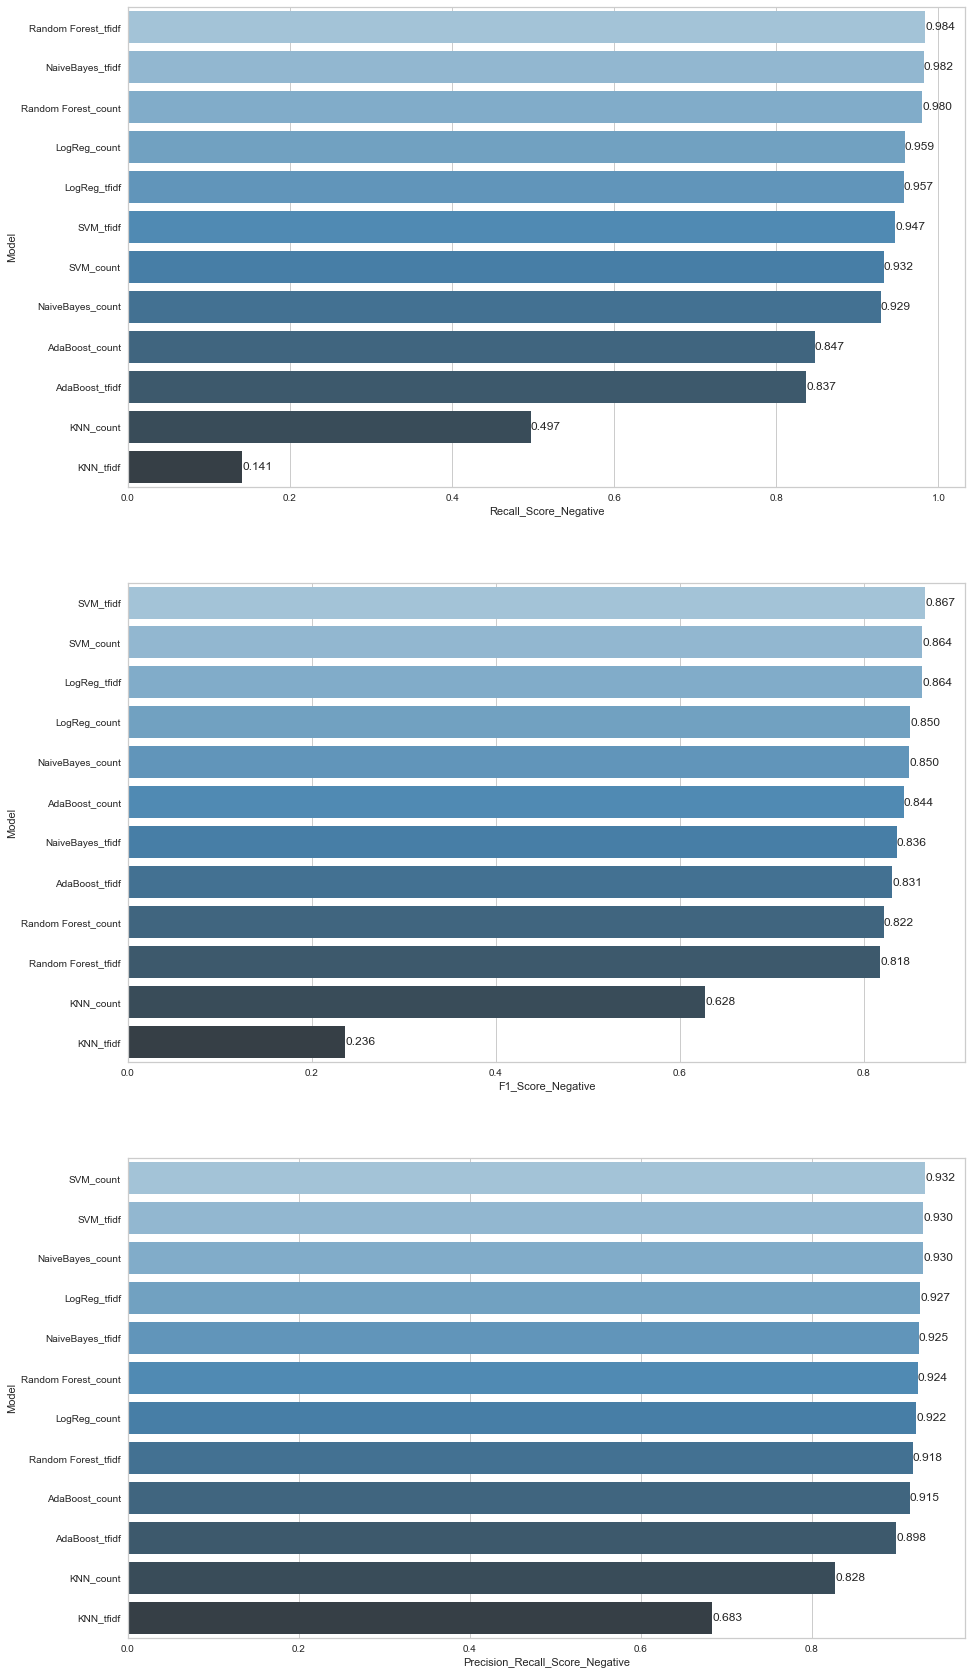

In [238]:
compare = pd.DataFrame({"Model": ["NaiveBayes_count", "LogReg_count", "SVM_count", "KNN_count", "Random Forest_count", 
                                  "AdaBoost_count", "NaiveBayes_tfidf", "LogReg_tfidf", "SVM_tfidf", "KNN_tfidf", 
                                  "Random Forest_tfidf", "AdaBoost_tfidf"],
                        
                        "F1_Score_Negative": [nb_count_f1_neg[0], log_count_f1_neg[0], svc_count_f1_neg[0], knn_count_f1_neg[0],
                                             rf_count_f1_neg[0], ada_count_f1_neg[0], nb_tfidf_f1_neg[0], log_tfidf_f1_neg[0],
                                             svc_tfidf_f1_neg[0], knn_tfidf_f1_neg[0], rf_tfidf_f1_neg[0], ada_tfidf_f1_neg[0]],
                        
                        "Recall_Score_Negative": [nb_count_rec_neg[0], log_count_rec_neg[0], svc_count_rec_neg[0], 
                                                  knn_count_rec_neg[0], rf_count_rec_neg[0], ada_count_rec_neg[0], 
                                                  nb_tfidf_rec_neg[0], log_tfidf_rec_neg[0], svc_tfidf_rec_neg[0], 
                                                  knn_tfidf_rec_neg[0], rf_tfidf_rec_neg[0], ada_tfidf_rec_neg[0]],
                        
                        "Precision_Recall_Score_Negative": [nb_AP_neg, log_AP_neg, svc_AP_neg, knn_AP_neg, rf_AP_neg,
                                                          ada_AP_neg, nb_tfidf_AP_neg, log_tfidf_AP_neg, svc_tfidf_AP_neg,
                                                           knn_tfidf_AP_neg, rf_tfidf_AP_neg, ada_tfidf_AP_neg]})

def labels(ax):
                        
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(15,30))
plt.subplot(311)
compare = compare.sort_values(by="Recall_Score_Negative", ascending=False)
ax=sns.barplot(x="Recall_Score_Negative", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="F1_Score_Negative", ascending=False)
ax=sns.barplot(x="F1_Score_Negative", y="Model", data=compare, palette="Blues_d")
labels(ax)


plt.subplot(313)
compare = compare.sort_values(by="Precision_Recall_Score_Negative", ascending=False)
ax=sns.barplot(x="Precision_Recall_Score_Negative", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show();

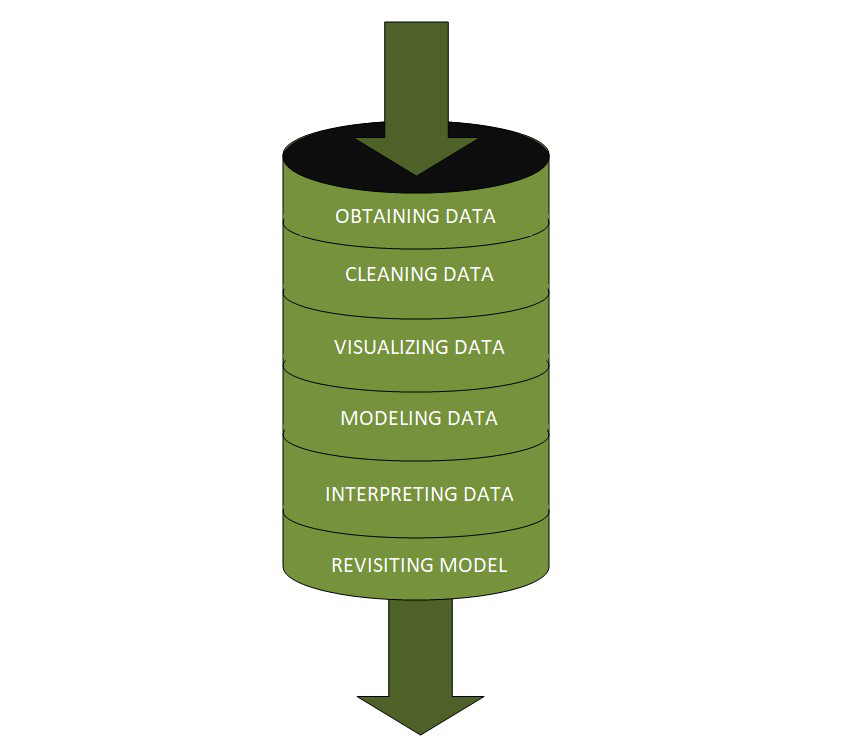

## For New Tweets, prediction with pipeline


In [239]:
from sklearn.pipeline import Pipeline

In [240]:
pipe = Pipeline([('tfidf',TfidfVectorizer(preprocessor=cleaning, min_df=3)),('log',LogisticRegression(C=0.4, max_iter=1000))])

In [241]:
pipe.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3,
                                 preprocessor=<function cleaning at 0x0000026358E63430>)),
                ('log', LogisticRegression(C=0.4, max_iter=1000))])

In [242]:
tweet = "it was not the worst flight i have ever been"
tweet = pd.Series(tweet) #bunun ciktisinasil acaba bak bir ara
pipe.predict(tweet) #pipe bizim modelimizin adi,traindeki tweetler ile egitilmis bir model

array(['negative'], dtype=object)

In [243]:
tweet = "didn't enjoy flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [244]:
tweet = "it is amazing"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [245]:
tweet = "it isn't amazing"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [246]:
tweet = "don't enjoy flight  at all"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [247]:
tweet = "I don't think I'll ever use American Airlines any more"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [248]:
tweet = "I don't love the flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [ ]:
#burda tahminleri görüyoruz

## Collect Words and Counting words

In [ ]:
#bunu galiba en asagida Wordcloud yapmak icin hazirliyorlar

In [249]:
tweets = cleaning_text
tweets

0                                                     said
1             plus youve added commercial experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving minute late flight no warning communic...
14637                        please bring american airline
14638    money change flight dont answer phone suggesti...
14639    ppl need know many seat next flight plz put u ...
Name: text, Length: 14640, dtype: object

In [250]:
all_words = " ".join(tweets)

In [251]:
all_words[:100]

'said plus youve added commercial experience tacky didnt today must mean need take another trip reall'

In [252]:
counter = Counter(word_tokenize(all_words))

In [253]:
counter.most_common()

[('flight', 4524),
 ('not', 1624),
 ('no', 1486),
 ('get', 1374),
 ('hour', 1138),
 ('thanks', 1073),
 ('cancelled', 1048),
 ('u', 994),
 ('service', 987),
 ('time', 946),
 ('customer', 930),
 ('help', 849),
 ('bag', 765),
 ('im', 743),
 ('plane', 724),
 ('amp', 678),
 ('hold', 642),
 ('need', 633),
 ('thank', 602),
 ('one', 580),
 ('still', 578),
 ('cant', 575),
 ('please', 562),
 ('call', 561),
 ('would', 549),
 ('day', 549),
 ('airline', 546),
 ('gate', 541),
 ('delayed', 530),
 ('back', 525),
 ('flightled', 506),
 ('dont', 490),
 ('seat', 480),
 ('got', 480),
 ('phone', 453),
 ('delay', 434),
 ('like', 432),
 ('today', 427),
 ('late', 424),
 ('guy', 423),
 ('agent', 416),
 ('know', 381),
 ('fly', 380),
 ('ticket', 380),
 ('make', 375),
 ('airport', 366),
 ('waiting', 366),
 ('change', 359),
 ('way', 358),
 ('trying', 348),
 ('minute', 345),
 ('go', 336),
 ('great', 335),
 ('ive', 328),
 ('wait', 326),
 ('going', 324),
 ('never', 319),
 ('problem', 312),
 ('min', 309),
 ('tomorrow',

In [254]:
for i in counter.most_common():
    if "enjoy" == i[0]:
        print(i)

('enjoy', 21)


In [255]:
for i in counter.most_common():
    if "love" == i[0]:
        print(i)

('love', 240)


In [256]:
for i in counter.most_common():
    if "like" == i[0]:
        print(i)

('like', 432)


In [257]:
counter = 0
for i,j in enumerate(tweets):
    if "love" in j and "dont" in j and y[i]=="negative":
        counter += 1
print(counter)      

5


In [258]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and "dont" in j and y[i]=="negative":
        counter += 1
print(counter)

30


In [259]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and "didnt" in j and y[i]=="negative":
        counter += 1
print(counter)

4


In [260]:
counter = 0
for i,j in enumerate(tweets):
    if "amazing" in j and "wasnt" in j and y[i]=="negative":
        counter += 1
print(counter)

0


In [261]:
counter = 0
for i,j in enumerate(tweets):
    if "love" in j and y[i]=="neutral":
        counter += 1
print(counter)

48


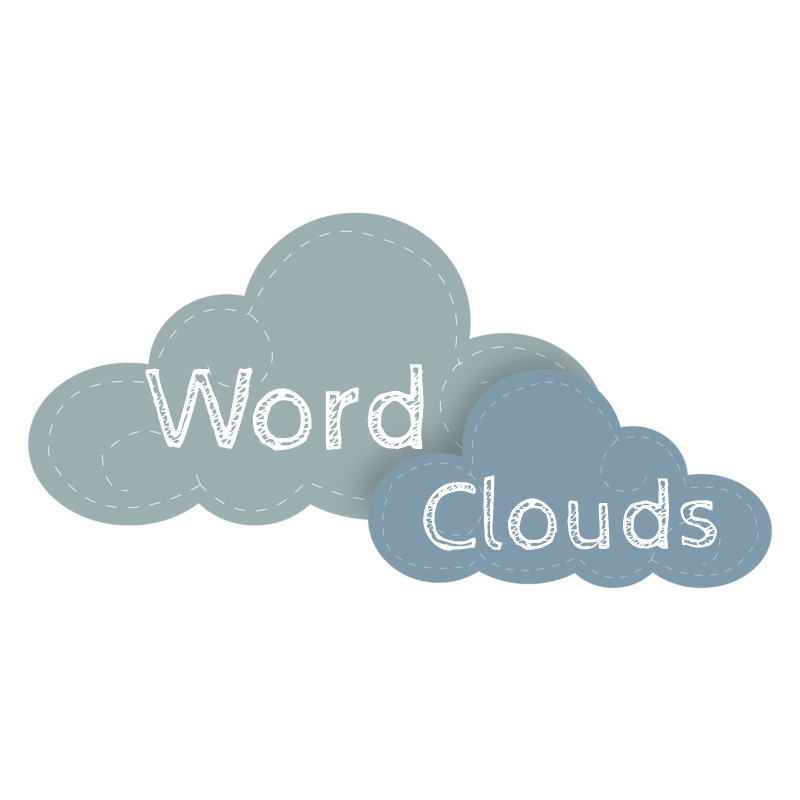

## WordCloud - Repetition of Words

## Collect Words

In [262]:
all_words = " ".join(tweets)

In [263]:
all_words[:100]

'said plus youve added commercial experience tacky didnt today must mean need take another trip reall'

## Create Word Cloud

In [34]:
!pip install wordcloud

     |████████████████████████████████| 160 kB 3.4 MB/s eta 0:00:01


In [265]:
from wordcloud import WordCloud

In [266]:
worldcloud = WordCloud(background_color="white", max_words =250)

In [267]:
worldcloud.generate(all_words)

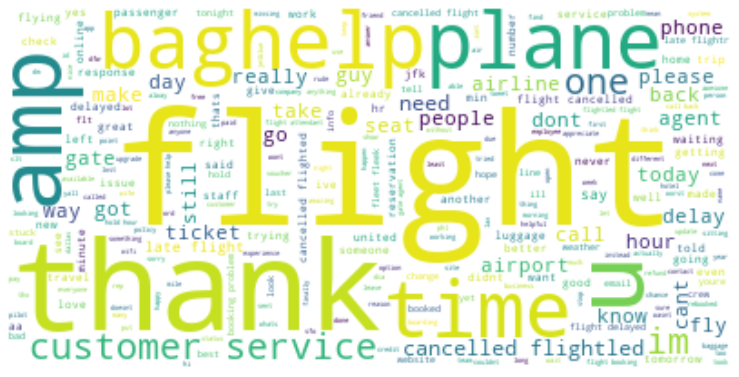

In [268]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13,13))
plt.imshow(worldcloud, interpolation="bilinear",)
plt.axis("off")
plt.show()

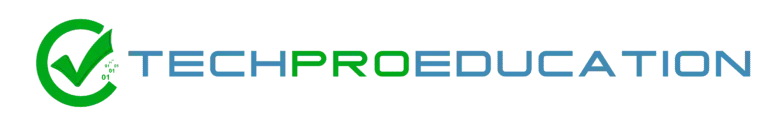